### **Connect Colab to Google drive**


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Go to project directory

In [2]:
cd drive/MyDrive/AML/

/content/drive/MyDrive/AML


### Install package


1.  Transformer for BERT model
2.  seqeval for evaluate training performance
3.  word segementation tools


    

In [3]:
!pip install --upgrade gspread

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [4]:
pip install transformers==3.0.2

     |████████████████████████████████| 778kB 6.9MB/s 
     |████████████████████████████████| 1.1MB 40.6MB/s 
     |████████████████████████████████| 890kB 52.6MB/s 
     |████████████████████████████████| 3.0MB 37.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=06a19733851ea0e3fe7632eb16d6e2488a21c80c0657fc89d87aaafc1b35a05d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
pip install seqeval==0.0.12

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=99ecee8a16767396c79e76ae1eca3ec504ccbf74a89575ff7f033484924d6cb4
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [6]:
pip install -U ckiptagger[tfgpu,gdown]

     |████████████████████████████████| 394.7MB 43kB/s 


### Load news to dataframe


In [ ]:
import pandas as pd
import os
import random
from buckytagger.NewsData import create_mini_batch, NewsDataset, NewsDoc
import torch
from transformers import BertForSequenceClassification
from transformers import BertTokenizer

filename = 'data/crime_news.xlsx'
excel = pd.read_excel(filename)


#### Your name here#####
studentName = 'Anderson'
########################

In [ ]:
def data_to_sheet(worksheet,content,label):
  data = worksheet.get_all_values()
  count = len(data)
  worksheet.update_cell(count+1, 1, content)
  worksheet.update_cell(count+1, 2, label)
  #### Add your name to google sheet#####
  worksheet.update_cell(count+1, 3, studentName)
  ########################
  print(count)

### Collect labeled data from shared google sheet


In [ ]:
from google.colab import auth
import pandas as pd
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1OpTQvmsx4ONgwiJhJc6TvVkA5sg-1H9ae-2baRruch4/edit?usp=sharing').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()



# Prepare fine-tuning data

In [ ]:
titles = excel['標題'].tolist()
random.shuffle(titles)

for news in titles:
    label = input(news+'\n Negative news answer 2, otherwise 1, stop tagging 0\n')
    if label == '0':
      break
    while(label!='1' and label!='2'):
      label = input('Please enter correct lable!!!!!!')
      if label == '0':
        break
    data_to_sheet(worksheet,excel[excel['標題']==news].iloc[0]['內容'],int(label)-1)
# Convert to a DataFrame and render.
rows = worksheet.get_all_values()

df = pd.DataFrame.from_records(rows,columns=['內容','label','Name']).sample(frac=1)


df.head(round(len(rows)*0.9)).to_excel('data/TrainAML.xlsx')
df.tail(round(len(rows)*0.1)).to_excel('data/ValidateAML.xlsx')

NameError: ignored

In [ ]:
df = pd.DataFrame.from_records(rows,columns=['內容','label','Name']).sample(frac=1)

df.head(round(len(rows)*0.9)).to_excel('data/TrainAML.xlsx')
df.tail(round(len(rows)*0.1)).to_excel('data/ValidateAML.xlsx')

FileNotFoundError: ignored

In [ ]:
df.head(20)

### Start training your own model



In [ ]:
__PATH__ = 'data/'

# Use Pretrained model
PRETRAINED_MODEL_NAME = "buckytagger/models/RobertaWwmExtClassifier/"
NUM_LABELS = 2
BATCH_SIZE = 2
classifier_model_idx = 4

#### Set True if you need to train new model###
train = True

EPOCHS = 3

cuda_num = "cuda:0"
TrainFile = "TrainAML.xlsx"
ValidFile = "ValidateAML.xlsx"


#####Fine tuned model directory#####
ModelName = f"buckytagger/models/fine-tuned/"
##### 
root = os.path.join('', 'data')

def get_predictions(model, dataloader,device):
    predictions = None
    correct = 0
    tp = 0
    relative = 0
    unrelative = 0
    tn = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to(device) for t in data if t is not None]

            tokens_tensors, segments_tensors, masks_tensors, labels = data
            outputs = model(input_ids=tokens_tensors,
                            # token_type_ids=segments_tensors,
                            attention_mask=masks_tensors)
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)

            total += labels.size(0)
            correct += (pred == labels).sum().item()
            for i,la in enumerate(labels):
                if la == 1:
                    relative+=1
                    if pred[i] == 1:
                        tp+=1
                else:
                    unrelative+=1
                    if pred[i]==0:
                        tn+=1

            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))

    acc = correct / total
    print("relative accuracy = {}/{} = {}".format(tp,relative,tp/relative))
    print("unrelative accuracy = {}/{} = {}".format(tn,unrelative,tn/unrelative))
    return predictions, acc

def classifier():
    tokenizer = BertTokenizer.from_pretrained('hfl/chinese-roberta-wwm-ext')
    device = torch.device(cuda_num if torch.cuda.is_available() else "cpu")
    
    model = BertForSequenceClassification.from_pretrained(
        PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

    model = model.to(device)
    model.load_state_dict(
            torch.load(os.path.join(ModelName,
                'pytorch_model.bin'), map_location="cpu"))

    model.eval()

    def predict(doc):

        predset = NewsDoc(tokenizer=tokenizer, doc=doc)
        dataloader = torch.utils.data.DataLoader(
                predset,batch_size=1,shuffle=True,collate_fn=create_mini_batch)

        with torch.no_grad():

            data = next(iter(dataloader))

            if next(model.parameters()).is_cuda:
                data = [t.to(device) for t in data if t is not None]

            #if next(model.parameters()).is_cuda:
            #    data = [t.to(device) for t in data if t is not None]

            tokens_tensors, segments_tensors, masks_tensors, labels = data
            outputs = model(input_ids=tokens_tensors,
                            # token_type_ids=segments_tensors,
                            attention_mask=masks_tensors)
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)

        return bool(pred[0])

    return predict, None


if __name__ == "__main__":
    tokenizer = BertTokenizer.from_pretrained('hfl/chinese-roberta-wwm-ext')
    device = torch.device(cuda_num if torch.cuda.is_available() else "cpu")

    model = BertForSequenceClassification.from_pretrained(
        PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)


    model = model.to(torch.device(cuda_num if torch.cuda.is_available() else "cpu"))
    if train:
        best = 0.85
        trainset = NewsDataset(os.path.join(root, TrainFile), tokenizer=tokenizer)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                            collate_fn=create_mini_batch,shuffle=True)
        model.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

        for epoch in range(EPOCHS):

            running_loss = 0.0
            for data in trainloader:

                tokens_tensors, segments_tensors, \
                masks_tensors, labels = [t.to(device) for t in data]

                optimizer.zero_grad()

                outputs = model(input_ids=tokens_tensors,
                                # token_type_ids=segments_tensors,
                                attention_mask=masks_tensors,
                                labels=labels)

                loss = outputs[0]
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            _, acc = get_predictions(model, trainloader, device=device)

            print('[epoch %d] loss: %.3f, acc: %.3f' %
                (epoch + 1, running_loss, acc))
            print("Validate {}:".format(epoch+1))

            trainset = NewsDataset(os.path.join(root, ValidFile), tokenizer=tokenizer)
            testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                collate_fn=create_mini_batch)
            _, acc = get_predictions(model, testloader, device=device)
            if acc > best:
                best = acc
                model.save_pretrained(ModelName)
    else:
        trainset = NewsDataset(os.path.join(root, ValidFile), tokenizer=tokenizer)
        testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                  collate_fn=create_mini_batch)
        _, acc = get_predictions(model, testloader, device=device)
        print(acc)


data/TrainAML.xlsx
relative accuracy = 450/505 = 0.8910891089108911
unrelative accuracy = 247/295 = 0.8372881355932204
[epoch 1] loss: 189.454, acc: 0.871
Validate 1:
data/ValidateAML.xlsx
relative accuracy = 40/52 = 0.7692307692307693
unrelative accuracy = 30/37 = 0.8108108108108109
relative accuracy = 501/505 = 0.9920792079207921
unrelative accuracy = 246/295 = 0.8338983050847457
[epoch 2] loss: 129.018, acc: 0.934
Validate 2:
data/ValidateAML.xlsx
relative accuracy = 44/52 = 0.8461538461538461
unrelative accuracy = 26/37 = 0.7027027027027027
relative accuracy = 500/505 = 0.9900990099009901
unrelative accuracy = 291/295 = 0.9864406779661017
[epoch 3] loss: 68.972, acc: 0.989
Validate 3:
data/ValidateAML.xlsx
relative accuracy = 34/52 = 0.6538461538461539
unrelative accuracy = 32/37 = 0.8648648648648649


### Check GPU usage

In [ ]:
!nvidia-smi

Tue Dec  8 08:03:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    42W /  70W |   4527MiB / 15079MiB |     83%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###Install for creating word cloud

In [ ]:
!pip install wordcloud

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from buckytagger import segmentor

from PIL import Image
import numpy as np
ws = segmentor.extractor()
cls,_ = classifier()

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at hfl/chin

### Show predict result 


*   modify filepath to your own labeled file




In [ ]:
df = pd.read_excel('./data/ValidateAML.xlsx',usecols=['內容','label'])
Class = df.iloc[:,0].apply(lambda x : cls(str(x)))
df['Pred'] = Class

In [ ]:
df.head(20)

,內容,label,Pred
0,工商時報【魏喬怡╱台北報導】中信慈善基金會董事長辜仲諒被控涉掏空中信金、內線交易、炒股等三案...,1,True
1,整形界名醫倪宗亨前年11月，酒後和朋友在高雄市區飆車，結果撞傷一名陳姓女駕駛。倪宗亨第一時間...,1,True
2,台中沙鹿的茶館槍擊案兩名槍手犯案至今剛好滿三個月，不只沒被逮捕，反而還傳出已經逃亡到柬埔寨的...,1,True
3,W飯店郭姓女子命案，5天4夜花費最少70萬開趴狂歡，土豪哥的行徑，讓檢察官也搖頭，起訴書中痛...,1,True
4,新黨發言人王炳忠19日清晨6時36分在家裡用臉書直播，法務部調查局人員和警方持著法院的搜索票...,1,False
5,奇鋐公司的董事長夫人日前申報轉讓要出清持股1034張，不但讓奇鋐股價重挫跌停，甚至拖累到整個...,1,True
6,總經費高達一百四十九億元的台鐵「環島鐵路整體系統安全提昇計畫」驚爆重大官商勾結貪瀆弊案！涉...,1,True
7,（中央社記者劉世怡台北31日電）本名黃照岡的黃琪涉冒充他人名義，7次向知名飯店訂房取得優惠房...,1,True
8,記者王鼎鈞／台北報導 前新北市副市長許志堅涉貪遭收押，監委高鳳仙和尹祚芊30日立案調查，將深...,1,True
9,新黨發言人、青年軍成員王炳忠、侯漢廷等4人遭搜索，並押往調查局國安站，引發「綠色恐怖」質疑。...,1,False


In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
data_utils.download_data_gdown("./")
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

Downloading...
From: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
To: /content/drive/My Drive/AML/data.zip
1.88GB [00:25, 74.5MB/s]


### Segment and combine all contents

In [ ]:
text_list = ws(df[df['Pred']==True]['內容'].tolist())
flattened = [val for sublist in text_list for val in sublist]

### Show result that predicting content is negative news

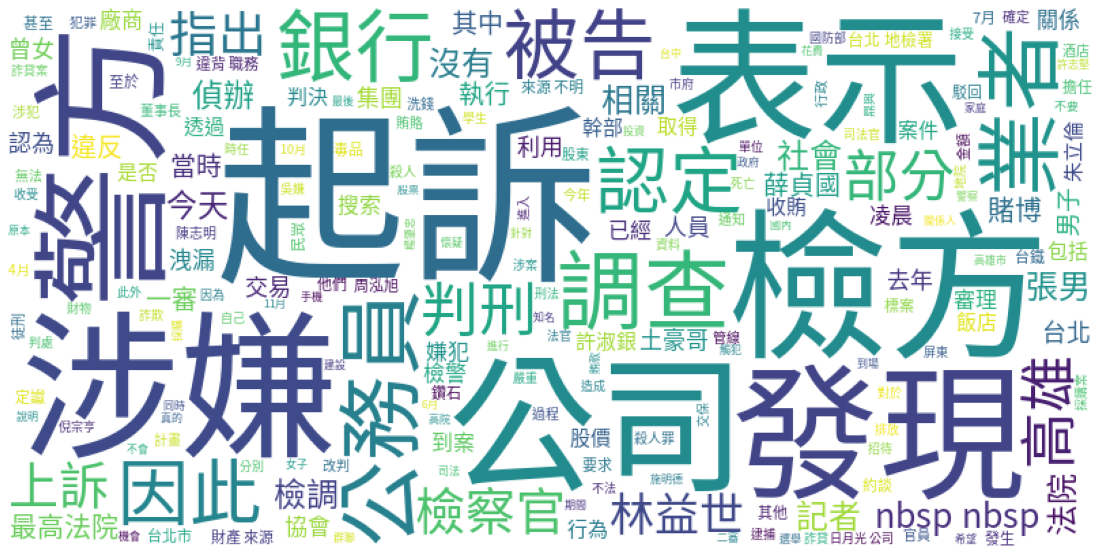

In [ ]:
#text = '下一代幸福聯盟等單位12月26日在立法院外抗議反同婚法案時，有159位參與翻牆入立法院被警方壓制。幸福盟指當日活動負責人趙曉音遭警方以束帶捆住，北北基安定力量聯盟秘書長游信義也在立院內遭立委黃國昌等人的助理拉扯，今早率眾向台北地檢署提告妨害自由。今天赴地檢署人士包括趙曉音、游信義、幸福盟家長代表曾獻瑩，以及多位翻牆入立院被警方壓制者。趙曉音表示，當天他本在警方許可下，帶醫療人員走入立院圍牆救護受傷的陳情民眾，卻被束帶銬住。他除提告妨害自由，也聲請保全證據，要求勘驗當天蒐證畫面。幸福盟也指出，當天在立法院司法及法制委員會內，主席尤美女宣讀通過同性婚入民法審查後，抗議民眾進入委員會，遭黃國昌助理陳志明、林靜儀助理王信允、蔡易餘助理張欽智等人壓制、搶奪小標語，認為國會殿堂是放任助理做維安，並指尤美女主持議事不公正。幸福盟也稱，當天抗議民眾是以和平方式翻入圍牆，卻被銬上束帶限制自由。他們質疑，這相對於318太陽花運動時學生占據議場酗酒，卻受總統蔡英文讚許，顯出小英不公。曾獻瑩在1226抗議前，曾稱幸福盟活動絕對反對暴力，但當日民眾翻牆入立院時，活動主持人一直喊「往前一步、衝進去」，被外界質疑是否有教唆犯罪之嫌，翻入立院者也恐遭提告。曾獻瑩指出，蔡英文曾說過民眾若表達什麼她沒聽見，「第三次可以拍桌」，他們只是和平理性翻牆進去表達意見，是在不得已下「公民不服從」的展示。翻牆者是否也遭警方提告，他們還在了解，至於警察在抗議中受傷，他們很遺憾。抗議同婚人士游信義。本報資料照分享'
#wordlist,_ = ws(text_list[0])
words = " ".join(flattened)#文字雲造型圖片

font = 'SourceHanSansTW-Regular.otf'#背景顏色預設黑色，改為白色、使用指定圖形、使用指定字體
my_wordcloud = WordCloud(background_color='white',font_path=font,width=800,height=400,).generate(words)
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(my_wordcloud)
plt.axis("off")
plt.show()

### Show content that is not negative related news

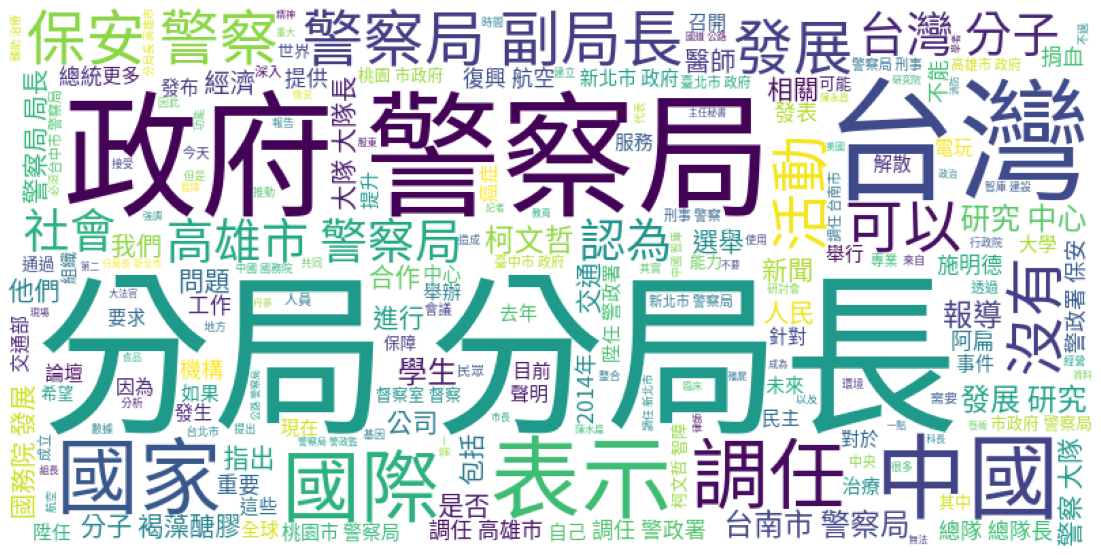

In [ ]:
text_list = ws(df[df['Pred']==False]['內容'].tolist())
flattened = [val for sublist in text_list for val in sublist]
words = " ".join(flattened)#文字雲造型圖片

font = 'SourceHanSansTW-Regular.otf'#背景顏色預設黑色，改為白色、使用指定圖形、使用指定字體
my_wordcloud = WordCloud(background_color='white',font_path=font,width=800,height=400,).generate(words)
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(my_wordcloud)
plt.axis("off")
plt.show()